In [10]:
"""Validates the adjoint gradient of a metalens in 3d."""

import meep as mp
import meep.adjoint as mpa
import numpy as np
import nlopt
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
from matplotlib import pyplot as plt

Air = mp.Medium(index=1.0)
SiN = mp.Medium(index=1.5)


resolution = 20 
Lpml = 0.5 
pml_layers = [mp.PML(thickness = Lpml, direction = mp.Z)]
Sourcespace = 0.5

design_region_width_x = 0.5
design_region_width_y = 0.5 
design_region_height = 0.5 

Sx = design_region_width_x
Sy = design_region_width_y
Sz = Lpml + design_region_height + Sourcespace + 1 + Lpml
cell_size = mp.Vector3(Sx, Sy, Sz)

wavelengths = np.array([0.5])
frequencies = 1/wavelengths
nf = len(frequencies) 

design_region_resolution = int(resolution)

fcen = 1 / 0.5
width = 0.1
fwidth = width * fcen

source_center = [0, 0, Sz / 2 - Lpml - Sourcespace / 2 ] 
source_size = mp.Vector3(Sx, Sy, 0)
src = mp.GaussianSource(frequency=fcen, fwidth=fwidth)
source = [mp.Source(src, component=mp.Ex, size=source_size, center=source_center,),]

Nx = int(round(design_region_resolution * design_region_width_x)) 
Ny = int(round(design_region_resolution * design_region_width_y)) 
Nz = int(round(design_region_resolution * design_region_height))

design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny, Nz), Air, SiN, grid_type="U_MEAN",do_averaging=False)
design_region = mpa.DesignRegion(
    design_variables,
    volume=mp.Volume(
        center=mp.Vector3(0, 0, Sz / 2 - Lpml - Sourcespace - design_region_height/2),
        size=mp.Vector3(design_region_width_x, design_region_width_y, design_region_height),
    ),
)

geometry = [
    mp.Block(
        center=design_region.center, size=design_region.size, material=design_variables
    ),
]

sim = mp.Simulation(
    cell_size=cell_size, 
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    default_material=Air, 
    resolution=resolution,
    k_point = mp.Vector3(0,0,0)
)

monitor_position_0, monitor_size_0 = mp.Vector3(-design_region_width_x/2, design_region_width_y/2, -Sz/2 + Lpml + 0.5/resolution), mp.Vector3(0.01,0.01,0) 

FourierFields_0_x = mpa.FourierFields(sim,mp.Volume(center=monitor_position_0,size=monitor_size_0),mp.Ex,yee_grid=True)


ob_list = [FourierFields_0_x]


def J(fields):
    return npa.mean(npa.abs(fields[:,1]) ** 2)

opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=[J],
    objective_arguments=ob_list,
    design_regions=[design_region],
    frequencies=frequencies,
    decay_by=1e-3,
)

     block, center = (0,0,0.25)
          size (0.5,0.5,0.5)
          axes (1,0,0), (0,1,0), (0,0,1)


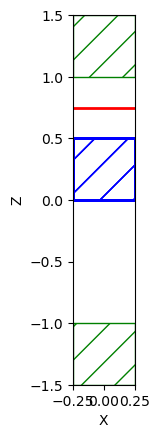

In [11]:
opt.plot2D(True,output_plane = mp.Volume(size = (np.inf, 0, np.inf), center = (0,0,0)))

     block, center = (0,0,0.25)
          size (0.5,0.5,0.5)
          axes (1,0,0), (0,1,0), (0,0,1)


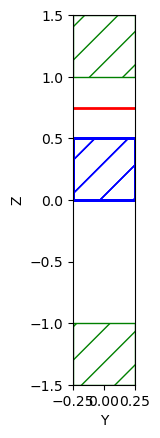

In [12]:
opt.plot2D(True,output_plane = mp.Volume(size = (0, np.inf, np.inf), center = (0,0,0)))

In [13]:
f0, dJ_du = opt()

Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.00272e-05 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 3 with resolution 20
     block, center = (0,0,0.25)
          size (0.5,0.5,0.5)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.0118251 s
-----------
run 0 finished at t = 50.425000000000004 (2017 timesteps)
Starting adjoint run...
run 1 finished at t = 113.05000000000001 (4522 timesteps)
Calculating gradient...


In [14]:
db = 1e-5
choose = 10
g_discrete, idx = opt.calculate_fd_gradient(num_gradients=choose, db=db)

-----------
Initializing structure...
time for choose_chunkdivision = 1.78814e-05 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 3 with resolution 20
     block, center = (0,0,0.25)
          size (0.5,0.5,0.5)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.0121369 s
-----------
run 2 finished at t = 50.050000000000004 (2002 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 1.5974e-05 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 3 with resolution 20
     block, center = (0,0,0.25)
          size (0.5,0.5,0.5)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.0119019 s
-----------
run 3 finished at t = 50.050000000000004 (2002 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 1.50204e-05 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 3 with resolution 20
     block, center = (0,0,0.25)
          size (0.5,0.5,0.5)
          axes (1,0,0), (0,1,0)

In [15]:
(m, b) = np.polyfit(np.squeeze(g_discrete), dJ_du[idx], 1)

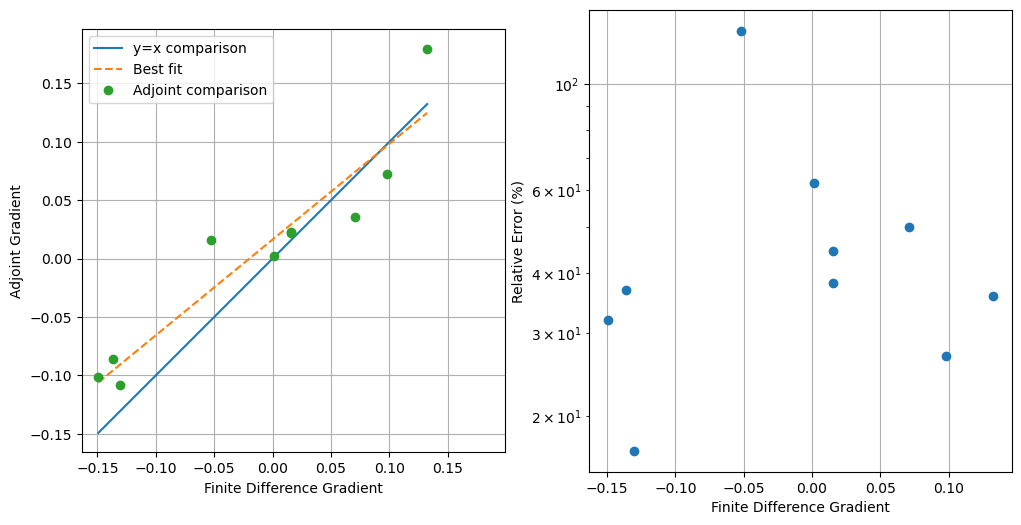

In [16]:
min_g = np.min(g_discrete)
max_g = np.max(g_discrete)

fig = plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot([min_g, max_g], [min_g, max_g], label="y=x comparison")
plt.plot([min_g, max_g], [m * min_g + b, m * max_g + b], "--", label="Best fit")
plt.plot(g_discrete, dJ_du[idx], "o", label="Adjoint comparison")
plt.xlabel("Finite Difference Gradient")
plt.ylabel("Adjoint Gradient")
plt.legend()
plt.grid(True)
plt.axis("square")

plt.subplot(1, 2, 2)
rel_err = (
    np.abs(np.squeeze(g_discrete) - np.squeeze(dJ_du[idx]))
    / np.abs(np.squeeze(g_discrete))
    * 100
)
plt.semilogy(g_discrete, rel_err, "o")
plt.grid(True)
plt.xlabel("Finite Difference Gradient")
plt.ylabel("Relative Error (%)")
plt.show()

plt.savefig("graph.png")
plt.cla()   # clear the current axes
plt.clf()   # clear the current figure
plt.close() # closes the current figure
plt.show()

In [17]:
print(idx)

[209 355  24 642 191 243 843  60 157 804]


In [18]:
db = 1e-5
choose = 1000
g_discrete, idx = opt.calculate_fd_gradient(num_gradients=choose, db=db)

-----------
Initializing structure...
time for choose_chunkdivision = 1.88351e-05 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 3 with resolution 20
     block, center = (0,0,0.25)
          size (0.5,0.5,0.5)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.0163639 s
-----------
run 22 finished at t = 50.050000000000004 (2002 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 1.62125e-05 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 3 with resolution 20
     block, center = (0,0,0.25)
          size (0.5,0.5,0.5)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.01334 s
-----------
run 23 finished at t = 50.050000000000004 (2002 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 1.78814e-05 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 3 with resolution 20
     block, center = (0,0,0.25)
          size (0.5,0.5,0.5)
          axes (1,0,0), (0,1,0

In [19]:
print(idx)

range(0, 1000)


In [20]:
db = 1e-5
choose = 999
g_discrete, idx = opt.calculate_fd_gradient(num_gradients=choose, db=db)

-----------
Initializing structure...
time for choose_chunkdivision = 1.90735e-05 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 3 with resolution 20
     block, center = (0,0,0.25)
          size (0.5,0.5,0.5)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.012048 s
-----------
run 2022 finished at t = 50.050000000000004 (2002 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 1.78814e-05 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 3 with resolution 20
     block, center = (0,0,0.25)
          size (0.5,0.5,0.5)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.0125341 s
-----------
run 2023 finished at t = 50.050000000000004 (2002 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 1.69277e-05 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 3 with resolution 20
     block, center = (0,0,0.25)
          size (0.5,0.5,0.5)
          axes (1,0,0), (

In [21]:
print(idx)

[982 120  42 787  49 958 718 344 218 813 387 755 719 872 467 708 745 375
   8 606 913 484  87 426 456  97  79 259 614 677 269 435 477 402 869 620
 859 824 609 310 628 899 847 153 485 266 421 700 818  47 372 146 837 664
 431 476 157  48 542 147  24 800 674 638 393  86 736 660 453 926 142 564
 907 986 104 990 989 835 555 622 167 550  57   3 425 865 831 330 511 201
 877 174 271 937 349 378 830 886 767 198 874 313 369 154 726 493 563 145
 615 483 355 497 723 918 706 149 950 481 920 626 311 323 596 277  95 397
 406 289 788 249 928 968 671 282 715 917 245 897 768 935  41 771 996 866
 974 705 413 995 921 251 516 141 892 127 208 939 280 273 964 360 385 528
 202 915 276 805 959 317 264 478 970 529 333 923  40 770  37 490 676 566
 931 462 680 401 193 634  36 821 255 547 879 223 949 759 410  25 760 119
 173 498 494 702 823 898 891 661 449 274 381 341 991 507 239 439 701 734
  82 102 720 451 115 764 729 588  23 532 131 625 967 725 594  11 852 731
 665 329 598 703 694 117 799 783 586 346 190 599 63